In [0]:
# for combining all the masks into one single mask and resizing all the pics to 256*256

import os
import numpy as np
from PIL import Image
import shutil

path1 = []

# def something():

input_path = '/Users/akshaytiwari/Downloads/Pythonfiles/data-science-bowl-2018/input/'
target_path = '/Users/akshaytiwari/Downloads/Pythonfiles/data-science-bowl-2018/target/'
path_ = '/Users/akshaytiwari/Downloads/Pythonfiles/stage1_train/'

for o,u in enumerate(os.scandir(path_)):
    if os.path.isdir(u.path):

        ty = np.zeros((256, 256))    # empty should be studied.

        for i in os.scandir(u.path+'/images'):
            inputs = np.asarray(Image.open(i.path))
            image = inputs[:256,:256,:4]
            zeros = np.zeros((256,256,4))
            zeros[:image.shape[0],:image.shape[1],:image.shape[2]]=image
            uu_ = Image.fromarray(zeros.astype('uint8'))
            uu_.save(input_path+f'input_{o}.png')            # try different formats to save

        for i in os.scandir(u.path+'/masks'):
            path1.append(u.path)
            image = np.asarray(Image.open(i.path))
            image = image[:256,:256]
            zeros = np.zeros((256,256))
            zeros[:image.shape[0],:image.shape[1]]=image

            ty += (zeros)


        uu = Image.fromarray(ty.astype('uint8'))
        uu.save(target_path+f'target_{o}.png')
#         if o==56:
#             return image.shape[1]                                                             

In [0]:
from fastai import *
from fastai.vision import *

In [0]:
bs = 8

label = '/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/data-science-bowl-2018/target/'
label_func = lambda x : label + 'target_'+ (x.name).split('_')[1]

IL = ImageImageList.from_folder('/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/data-science-bowl-2018/input')
LL = IL.split_by_rand_pct(valid_pct=0.2).label_from_func(label_func)
data = LL.transform(get_transforms(max_lighting=None,max_warp=None),tfm_y = True).databunch(bs=bs).normalize(imagenet_stats,do_y=True)


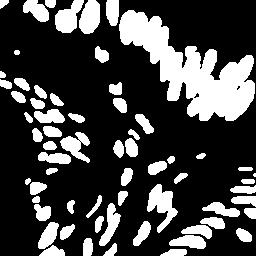

In [12]:
data.train_ds.y[0]

In [13]:
import fastai                                   
import torch                                  
from fastai import *                          
from fastai.vision import *                 
from fastai.callbacks import *               
from fastai.utils.mem import *               
from torchvision.models import vgg16_bn 

arch = models.resnet34

def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)          


base_loss = F.l1_loss


vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)


blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]


class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()


feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [15]:
wd = 1e-03

learn = unet_learner(data=data,arch = arch,wd=wd,loss_func=feat_loss,
             blur=True,norm_type=NormType.Weight)

gc.collect();

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,time
0,5.341887,#na#,03:28


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


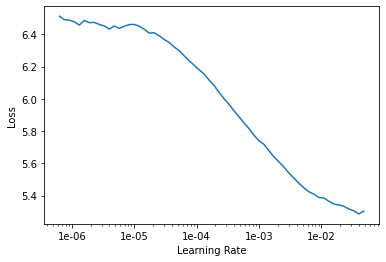

In [16]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 8e-04

In [0]:
def Do_fit(save_name,lr):
  learn.fit_one_cycle(10,lr,pct_start=0.7)
  learn.save(save_name)
  learn.show_results(rows=1,imgsize=5)

epoch,train_loss,valid_loss,time
0,3.938610,3.676579,01:32
1,3.374704,3.431044,00:50
2,3.158707,2.961636,00:51
3,2.846533,2.813332,00:50
4,2.796076,2.724455,00:50
5,2.680033,2.609781,00:50
6,2.324922,2.383000,00:50
7,1.855416,1.638418,00:50
8,1.395918,1.340251,00:50
9,1.091318,1.234809,00:50


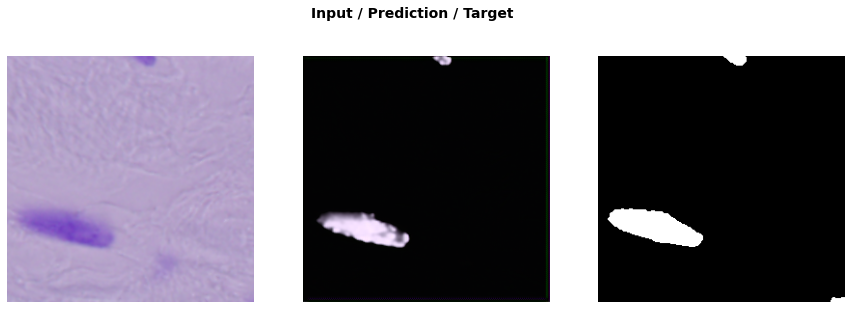

In [20]:
Do_fit('freeze_cell',slice(lr*10))

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,time
0,0.953572,1.222891,00:51
1,0.926638,1.194126,00:52
2,0.886310,1.168250,00:52
3,0.876392,1.126490,00:52
4,0.876168,1.140949,00:52
5,0.861232,1.087060,00:52
6,0.839830,1.068877,00:52
7,0.840301,1.133851,00:52
8,0.780905,1.026126,00:52
9,0.752744,1.021938,00:52


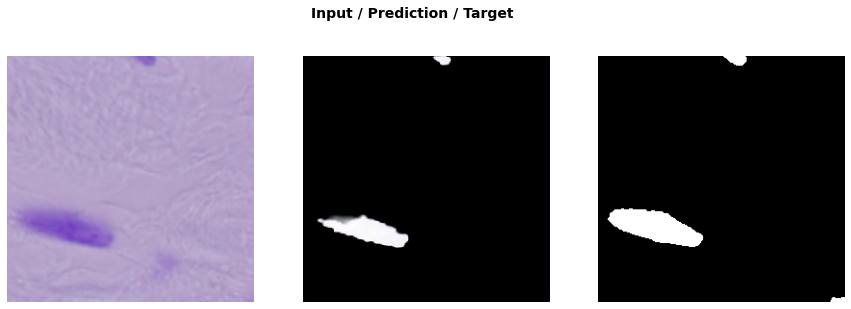

In [23]:
Do_fit('unfreeze_cell',slice(lr/10,lr))  

In [0]:
learn.export('/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/data-science-bowl-2018/cell_model.hdf5')

In [0]:
import json
import pandas as pd
import nibabel as nib
from matplotlib import pyplot as plt
import os


with open('/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/Task09_Spleen/dataset.json') as d:
  json = json.load(d)

path = '/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/Task09_Spleen'


def real():    

  i = 0

  for u in json['training']:
    input_ = u['image']
    label_ = u['label']
    input_path = "".join(list(input_)[1:])
    label_path = "".join(list(label_)[1:])
    images = nib.load(path+input_path)
    labels = nib.load(path+label_path)

    if not os.path.exists(path+'/input'):
      os.mkdir(path+'/input')
    if not os.path.exists(path+'/target'):
      os.mkdir(path+'/target')

    for third in range(images.shape[2]):
      image_ = images.get_data()[:,:,third]
      target_ = labels.get_data()[:,:,third]
      plt.imshow(image_)
      plt.axis('off')
      plt.figure(figsize=(3.5,3.5))
      plt.savefig(path+'/input'+f'/input_{i}.jpg')
      
      plt.imshow(target_)
      plt.axis('off')
      plt.figure(figsize=(3.5,3.5))
      plt.savefig(path+'/target'+f'/target{i}.jpg')
      i += 1
      if 1==150:
        return "fgj"

In [0]:
path = '/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/Task09_Spleen/target/'
# path1 = '/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/Task09_Spleen/input/'

label_func = lambda x : path + 'target'+(x.name).split("_")[1]  #input_{i}.jpg
# same_func = lambda x: path1+x.name

IL = ImageImageList.from_folder('/content/drive/My Drive/Colab_Notebooks/Medical_segmentation/Task09_Spleen/input/')
LL = IL.split_by_rand_pct(valid_pct=0.2).label_from_func(label_func)
data = LL.transform(get_transforms(max_rotate=None, max_zoom=1, max_lighting=None, max_warp=None),tfm_y=True).databunch(bs=8).normalize(imagenet_stats,do_y=True)
